Very brief introduction:
Inspired by Andrew Ng's Coursera's Machien Learning module on anomoly detection, this notebook presents and explains some sci-kit learn functionality. Specifically, Sci-kit Learn's EllipticEnvelope and XXXXXXX functions are implemented.

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import bivariate_normal
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Loading data provided by Coursera, Machine Learning. Exercise 8.
drive = 'C:\\Users\\Raphael\\Dropbox\\pywork\\Coursera ML\\machine-learning-ex8\\ex8\\'
f = sio.loadmat(drive+'ex8data1.mat')
X = f['X']
Xval = f['Xval']
yval = f['yval']

By inspection, six points are suspect outliers. The question here, in this 2 dimensional space, is how can we identify them programmatically.

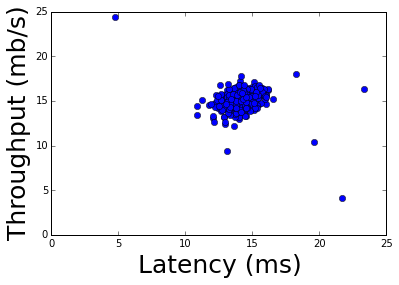

In [2]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
ax.plot(X[:, 0], X[:, 1], 'o')
plt.xlabel('Latency (ms)', fontsize=25)
plt.ylabel('Throughput (mb/s)', fontsize=25)
plt.show()

One approach is to assume the data is bivariate normal and identify as outliers those that are too far away from the center. So we're clear about what we mean by this, here is the same above plot however with an estimated bivariate normal density included as well.

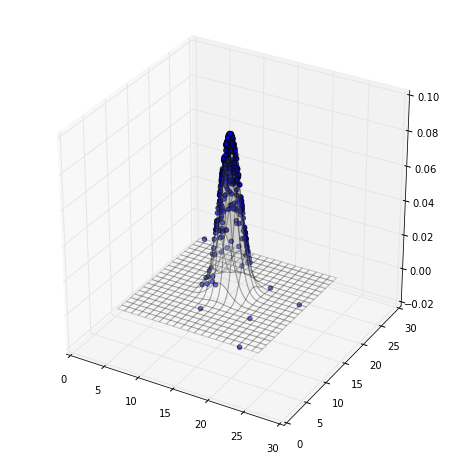

In [5]:
xbar = X.mean(axis=0)
s2 = X.var(axis=0)
s = np.sqrt(s2)
p = multivariate_normal(mean=xbar, cov=s2).pdf(X)

x = np.linspace(X.min(), X.max(), 200)
Xm, Ym = np.meshgrid(x, x)
Zm = bivariate_normal(Xm, Ym,
					  sigmax=s[0], sigmay=s[1], mux=xbar[0], muy=xbar[1])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xm, Ym, Zm, cmap='binary', alpha=.2)
ax.scatter(X[:, 0], X[:, 1], p, c='blue', zdir='z', alpha=.7)
plt.show()

Note that when we estimated the density, we used the sample mean and variance. Effectively, I used the outliers (potentially, the "bad" data) in that calculation. Scikit-learn provides an alternative that does this in such a way that the outliers do not influence the estimated density--EllipticEnvelope. The catch here is that it must be told what portion of the data are suspected outliers. The parameter is called contamination. Given that this example came from a class where there was a "correct answer," I used that as the parameter--7.
The code below runs the classifier (clf, as it classifies outliers vs inliers) on our data, X. The preds are the predicted classes -1 for outlier and 1 for inlier. 

In [6]:
from sklearn.covariance import EllipticEnvelope

clf = EllipticEnvelope(contamination=7/X.shape[0])
clf.fit(X)
preds = clf.predict(X)
predoutliers = np.where(preds==-1)
predinliers = np.where(preds==1)

Plotting the outliers, we see the 7 contaminators.

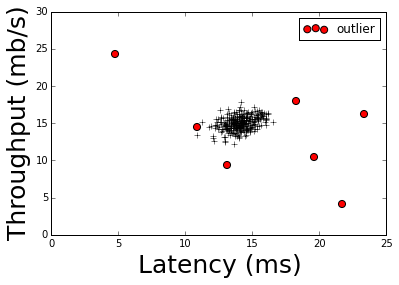

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(X[predinliers, 0], X[predinliers, 1], 'k+')
ax.scatter(X[predoutliers, 0], X[predoutliers, 1],
		   c='red', label='outlier', s=50)
plt.xlabel('Latency (ms)', fontsize=25)
plt.ylabel('Throughput (mb/s)', fontsize=25)
plt.legend()
plt.show()

How does this compare, though, to the "true" outliers? That is, how does this compare to what the dataset labeled as outliers? Recall that the inliers are noted as 1 and outliers are -1. The variable "actualoutliers" below is created by basically creating an array of ones and then changing the values where the "actual" outliers are to -1.

In [10]:
actualoutliers = np.ones(shape=preds.shape).astype(int)
actualoutliers[np.where(yval==1)[0]] = -1

I plot four sets of points below:
1) outliers exclusive to what was predicted by EllipticEvelope (uniq_to_pred)
2) outliers exclusive to what were labeled as outliers in the dataset (uniq_to_actual)
3) outliers that were common to both (1) and (2) above (inpredandinactual)
4) the inliers.

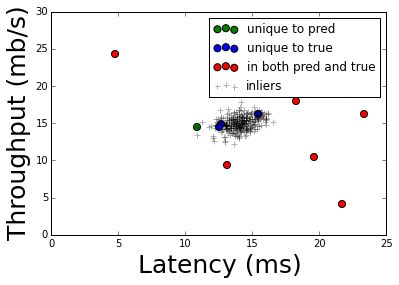

In [13]:
fig, ax = plt.subplots(1, 1)
ax.scatter(X[uniq_to_pred, 0], X[uniq_to_pred, 1], s=50, c='green',
		   label='unique to pred')
ax.scatter(X[uniq_to_actual, 0], X[uniq_to_actual, 1], s=50, c='blue',
		   label='unique to true')
ax.scatter(X[inpredandinactual, 0], X[inpredandinactual, 1], s=50, c='red',
		   label='in both pred and true')
ax.scatter(X[trueinliers, 0], X[trueinliers, 1], marker='+', c='black', s=30,
		   alpha=.3, label='inliers')
plt.xlabel('Latency (ms)', fontsize=25)
plt.ylabel('Throughput (mb/s)', fontsize=25)
plt.legend()
plt.show()

Why are there two datums above that do not appear to be outliers? My best guess is that these points served some purpose having to do with algorithm checking as part of Andrew Ng's coursework.